# Boston Housing Prices Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from dataclasses import dataclass

from sklearn import datasets
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import train_test_split

import graphviz 

%matplotlib inline

In [2]:
# Matplotlib has some built in style sheets
mpl.style.use('fivethirtyeight')

## Data Loading

Notice that I am loading in the data in the same way that we did for our visualization module. Time to refactor? It migth be good to abstract away some of this as functions, that way we aren't copying and pasting code between all of our notebooks.

In [3]:
boston = datasets.load_boston()

# Sklearn uses a dictionary like object to hold its datasets
X = boston['data']
y = boston['target']

feature_names = list(boston.feature_names)

In [4]:
X_df = pd.DataFrame(X)
X_df.columns = boston.feature_names
X_df["PRICE"] = y 

X_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [5]:
def create_classes(data):
    """Create our classes using thresholds
    
    This is used as an `apply` function for
    every row in `data`.
    
    Args:
        data: pandas dataframe
    """
    if data["PRICE"] < 16.:
        return 0
    elif data["PRICE"] >= 16. and data["PRICE"] < 22.:
        return 1
    else:
        return 2

In [6]:
y = X_df.apply(create_classes, axis=1)

# Get stats for plotting
classes, counts = np.unique(y, return_counts=True)

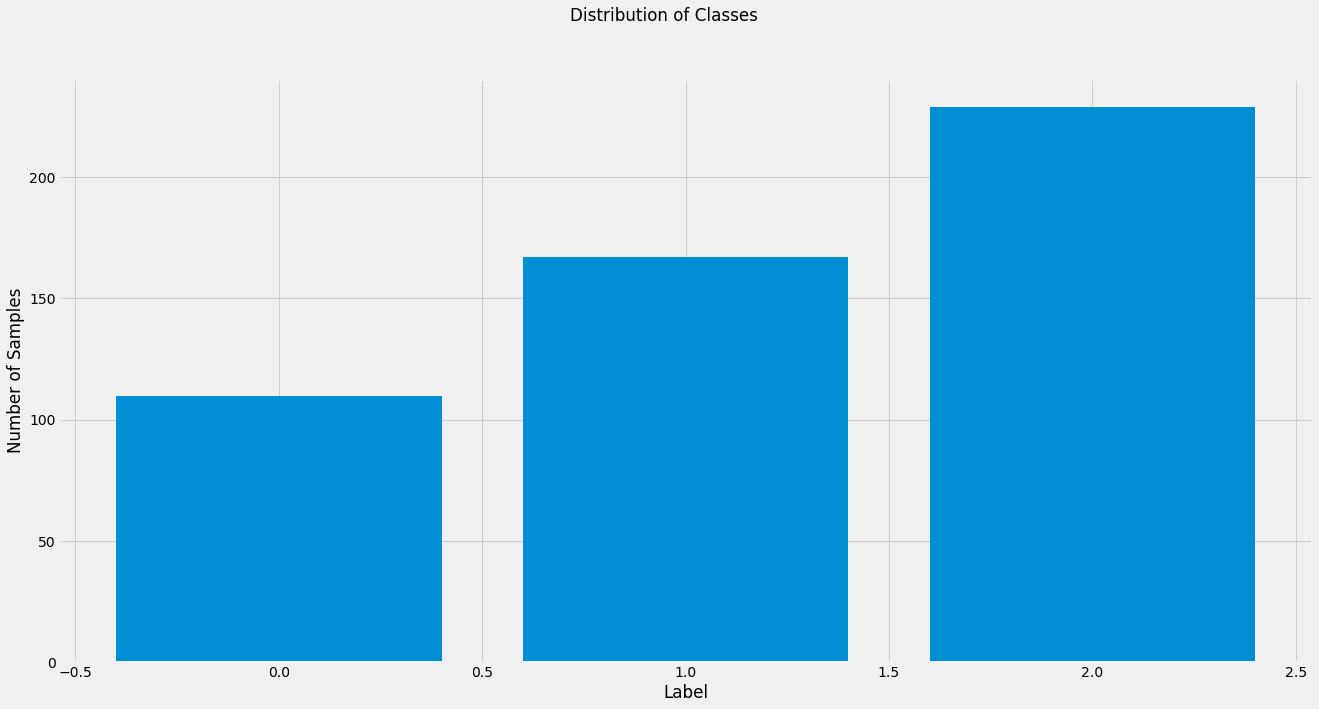

In [7]:
plt.figure(figsize=(20, 10))

plt.bar(classes, counts)

plt.xlabel("Label")
plt.ylabel(r"Number of Samples")
plt.suptitle("Distribution of Classes")
plt.show()

## Support Vector Machine

In [8]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Args:
        x: data to base x-axis meshgrid on
        y: data to base y-axis meshgrid on
        h: stepsize for meshgrid, optional

    Returns:
        xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Args:
        ax: matplotlib axes object
        clf: a classifier
        xx: meshgrid ndarray
        yy: meshgrid ndarray
        params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [9]:
# Careful, `loc` uses inclusive bounds!
X_smol = X_df.loc[:99, ['LSTAT', 'PRICE']].values
y_smol = y[:100]


C = 1.0 # SVM regularization parameter
models = [
    svm.SVC(kernel='linear', C=C),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel='rbf', gamma=0.7, C=C),
    svm.SVC(kernel='poly', degree=3, gamma='auto', C=C)
]

models = [clf.fit(X_smol, y_smol) for clf in models]

/Users/ygx/.local/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


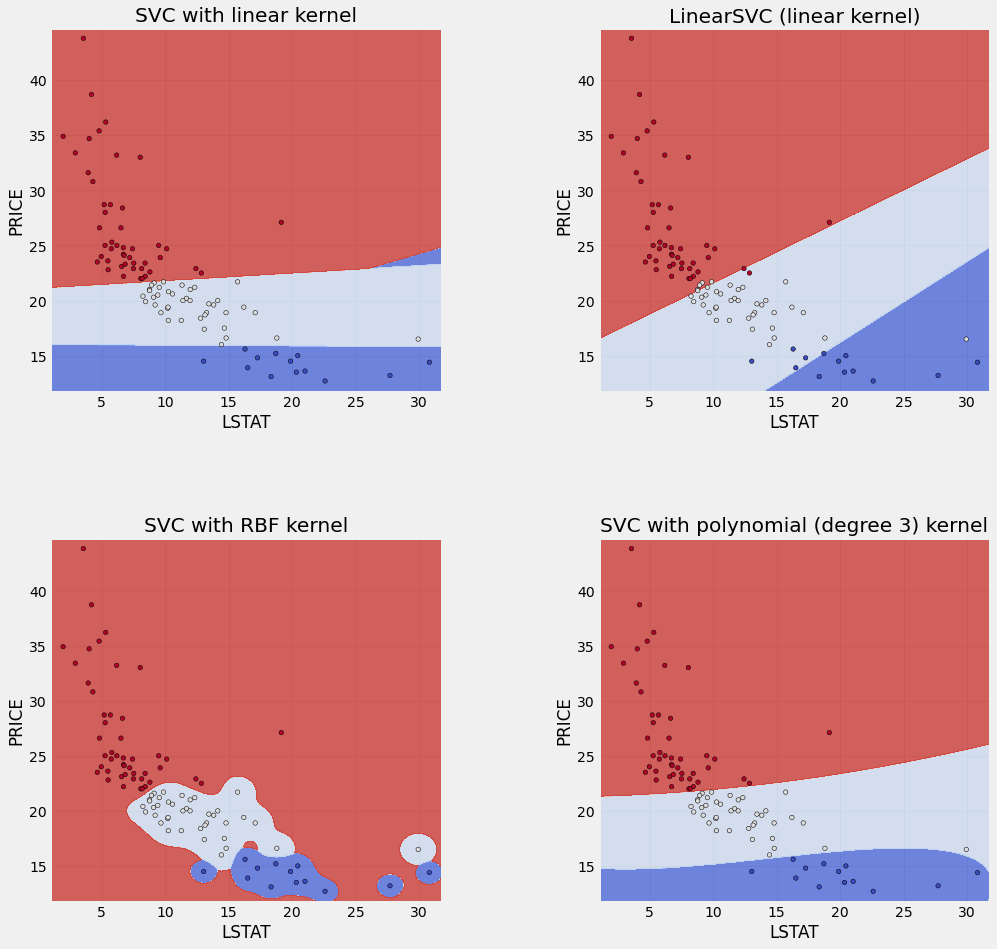

In [10]:
# title for the plots
titles = [
    'SVC with linear kernel',
    'LinearSVC (linear kernel)',
    'SVC with RBF kernel',
    'SVC with polynomial (degree 3) kernel'
]

# Set-up 2x2 grid for plotting.
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X_smol[:, 0], X_smol[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, axs.flatten()):
    plot_contours(
        ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8
    )
    ax.scatter(
        X0, X1, c=y_smol, cmap=plt.cm.coolwarm, s=20, edgecolors='k'
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('LSTAT')
    ax.set_ylabel('PRICE')
    ax.set_title(title)

plt.show()

## Modeling with Trees and Ensembles of Trees

In [11]:
@dataclass
class Hparams:
    """Hyperparameters for our models"""
    max_depth: int = 1
    min_samples_leaf: int = 1
    n_estimators: int = 400
    learning_rate: float = 1.0

In [12]:
hparams = Hparams()

In [13]:
# Keeping price in there is cheating
X_df = X_df.drop("PRICE", axis=1)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.33, random_state=42
)

In [15]:
dt_stump = DecisionTreeClassifier(
    max_depth=hparams.max_depth, 
    min_samples_leaf=hparams.min_samples_leaf
)

dt_stump.fit(X_df, y)
dt_stump_err = 1.0 - dt_stump.score(x_test, y_test)

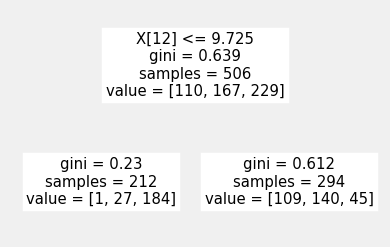

In [16]:
_ = tree.plot_tree(dt_stump) 

In [17]:
# Adding greater depth to the tree
dt = DecisionTreeClassifier(
    max_depth=9, # No longer using Hparams here!
    min_samples_leaf=hparams.min_samples_leaf
)

dt.fit(x_train, y_train)
dt_err = 1.0 - dt.score(x_test, y_test)

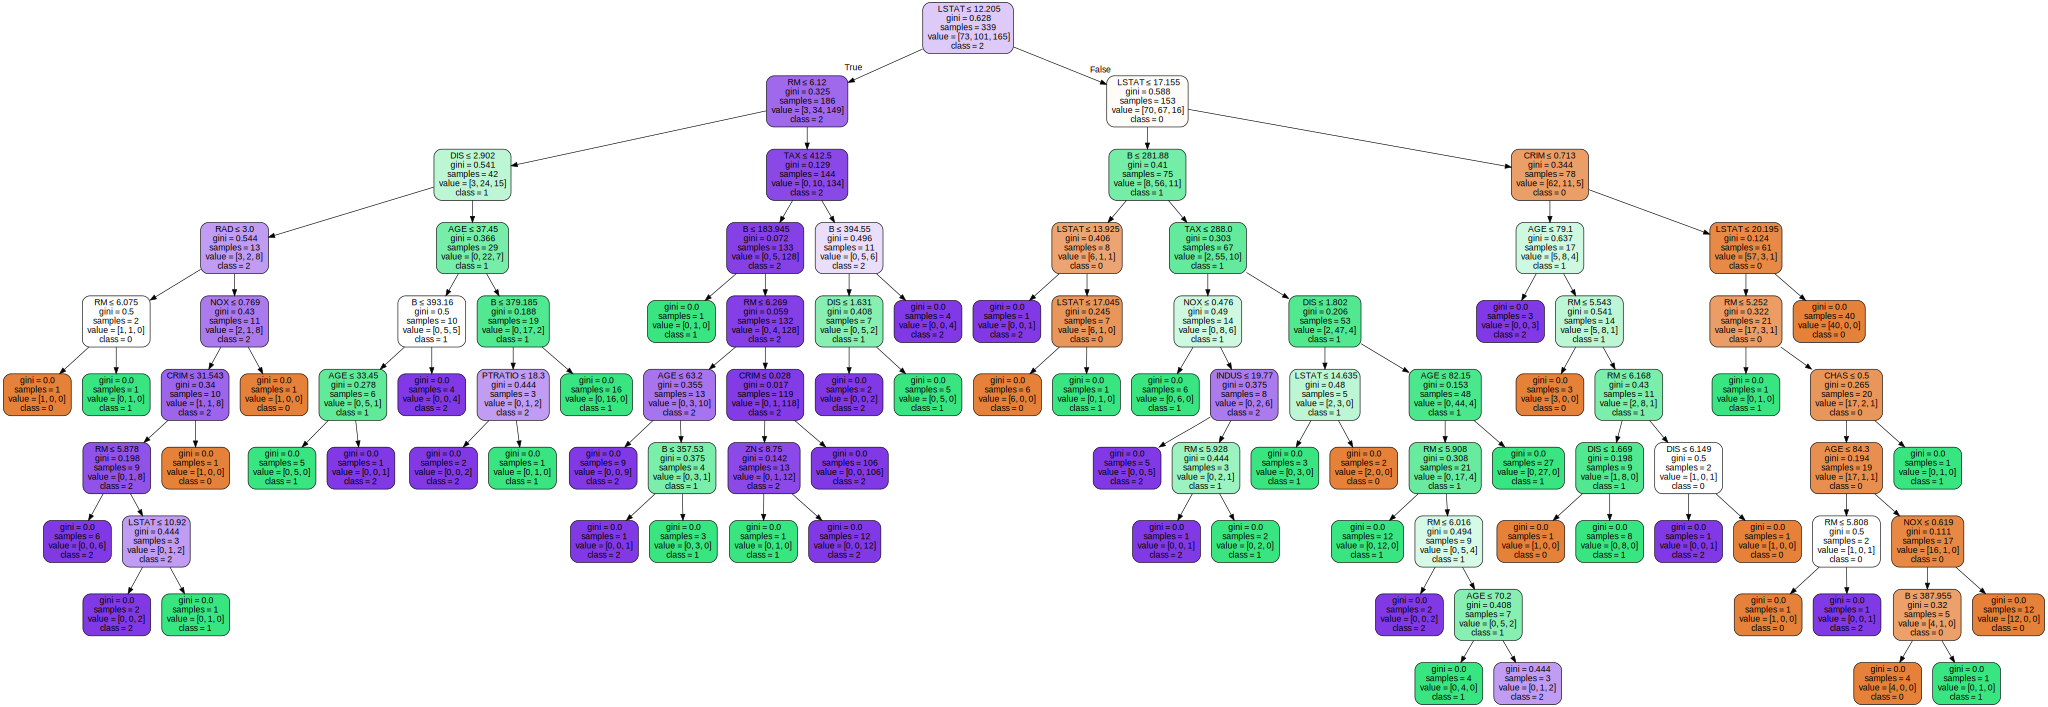

In [18]:
class_names = ['0', '1', '2']

dot_data = tree.export_graphviz(dt, out_file=None, 
                      feature_names=boston.feature_names,  
                      class_names=class_names,  
                      filled=True, rounded=True,  
                      special_characters=True) 

graph = graphviz.Source(dot_data)  
graph#.render("decision_tree_boston") 

### Adaboost

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits  additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [19]:
ada_discrete = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=hparams.learning_rate,
    n_estimators=hparams.n_estimators,
    algorithm="SAMME"
)

ada_discrete.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=400)

In [20]:
# Notice the `algorithm` is different here.
# This is just one parameter change, but it
# makes a world of difference! Read the docs!
ada_real = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=hparams.learning_rate,
    n_estimators=hparams.n_estimators,
    algorithm="SAMME.R" # <- take note!
)

ada_real.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   n_estimators=400)

In [21]:
def misclassification_rate_by_ensemble_size(model, n_estimators, data, labels):
    """Get the fraction of misclassifications per ensemble size 
    
    As we increase the number of trees in the ensemble,
    we often find that the performance of our model changes.
    This shows us how our misclassification rate changes as
    we increase the number of members in our ensemble up to
    `n_estimators`
    
    Args:
        model: ensembe model that has a `staged_predict` method
        n_estimators: number of models in the ensemble
        data: data to be predicted over
        labels: labels for the dataset
        
    Returns:
        misclassification_rate: numpy array of shape (n_estimators,)
        This is the fraction of misclassifications for the `i_{th}`
        number of estimators
    """
    misclassification_rate = np.zeros((n_estimators,))
    for i, y_pred in enumerate(model.staged_predict(data)):
        # zero_one_loss returns the fraction of misclassifications 
        misclassification_rate[i] = zero_one_loss(y_pred, labels)
        
    return misclassification_rate

In [22]:
# Get the misclassification rates for each algo on each data split
ada_discrete_err_train = misclassification_rate_by_ensemble_size(
    ada_discrete, hparams.n_estimators, x_train, y_train
)

ada_discrete_err_test = misclassification_rate_by_ensemble_size(
    ada_discrete, hparams.n_estimators, x_test, y_test
)

ada_real_err_train = misclassification_rate_by_ensemble_size(
    ada_real, hparams.n_estimators, x_train, y_train
)

ada_real_err_test = misclassification_rate_by_ensemble_size(
    ada_real, hparams.n_estimators, x_test, y_test
)

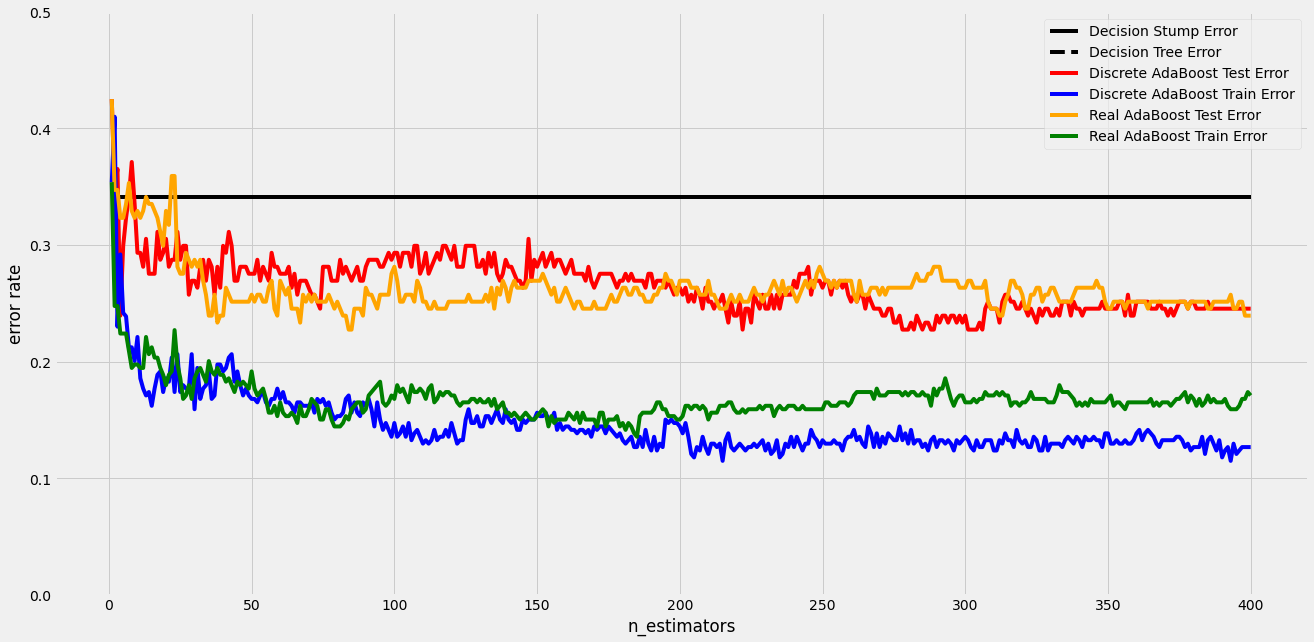

In [23]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot([1, hparams.n_estimators], [dt_stump_err] * 2, 'k-',
        label='Decision Stump Error')
ax.plot([1, hparams.n_estimators], [dt_err] * 2, 'k--',
        label='Decision Tree Error')

ax.plot(np.arange(hparams.n_estimators) + 1, ada_discrete_err_test,
        label='Discrete AdaBoost Test Error',
        color='red')

ax.plot(np.arange(hparams.n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='blue')

ax.plot(np.arange(hparams.n_estimators) + 1, ada_real_err_test,
        label='Real AdaBoost Test Error',
        color='orange')

ax.plot(np.arange(hparams.n_estimators) + 1, ada_real_err_train,
        label='Real AdaBoost Train Error',
        color='green')

ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)